In [1]:
import rec
import numpy as np

# The SIR model can be initialized with no parameters
sir = rec.SIRModel()

In [2]:
# Or we can specify parameters
sir = rec.SIRModel(num_users=10, num_items=100)
print("Num items", sir.num_items)
print("Num users", sir.num_users)

Num items 100
Num users 10


In [3]:
# Or better yet, we can specify our own representations for items and users,
# which were otherwise randomly generated.
# This has constraints that depend on the model

# user_representation must be a social graph
# Soon it'll be possible to define this easily with a SocialGraph class, but for now:
num_users, num_items = 10, 100
user_representation = rec.Distribution('binom', p=.3, n=1,
                                      size=(num_users, num_users)).compute()

# item_representation is an array of probabilities of infection:
# Similarly, this will become a Probability class that can take any distribution. For now:
item_representation = rec.Distribution('uniform', size=(1, num_items)).compute()

# And now we initialize the new model
sir = rec.SIRModel(item_representation=item_representation,
                  user_representation=user_representation)
print("Item attributes \n", sir.item_attributes)
print("User profiles\n", sir.user_profiles)

Item attributes 
 [[8.45765690e-01 5.00054752e-01 3.74406745e-01 5.58156713e-01
  9.79660287e-01 5.51545293e-01 3.75463131e-01 6.92780297e-01
  5.92632024e-01 6.23824421e-01 6.67320590e-01 3.05123995e-01
  4.89711208e-01 2.37560052e-01 6.48748618e-01 5.76905493e-01
  4.33640087e-01 7.16359122e-01 2.52536591e-01 2.68506885e-01
  5.30701433e-01 9.57723314e-01 5.45388901e-01 6.27437777e-01
  8.59282700e-01 8.23117941e-01 8.43897935e-01 7.60795726e-01
  8.11327705e-01 8.61411142e-01 6.54547616e-01 6.01716800e-01
  6.73625195e-01 5.04657546e-02 5.01574236e-01 8.78170572e-01
  2.81224135e-01 3.70116884e-01 5.78516596e-01 1.98394124e-01
  5.27479008e-01 5.86568508e-01 1.65536568e-01 5.10862777e-01
  9.51593313e-01 2.36385611e-01 8.35922807e-02 9.27620643e-01
  1.04066864e-01 2.85012226e-01 1.38467300e-01 5.53031658e-01
  6.86006182e-01 5.99043079e-01 7.80790266e-01 6.43792949e-01
  6.12910482e-01 3.28636874e-01 9.63071023e-01 6.57557284e-01
  3.70614775e-01 3.51406727e-01 3.77135768e-01 9.566

In [4]:
# We can also define the initial infection state -- that is, which user has been infected by which item
# before the simulation starts.
# Note that the model does not currently support modifying the parameters after initialization.
# So we need to initialize a new model altogether.

# But first, the initial infection state:
# (this will also be simplified, but I'm not sure how yet)
infection_state = rec.Distribution('binom', p=.3, n=1,
                                      size=(num_users, num_items)).compute()
sir = rec.SIRModel(item_representation=item_representation,
                  user_representation=user_representation,
                  infection_state=infection_state)
print("Initial infection state\n", sir.infection_state)

Initial infection state
 [[0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
  1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1
  0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0]
 [1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1
  0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0
  1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1]
 [0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0
  0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0
  1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1
  1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0
  0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0

In [5]:
# We could also specify an infection threshold, which specifies what is the minimum probability
# that the user will become 'infected' with items.
# Right now, infection_threshold is a scalar constant, but
# it will soon support arrays with a potentially different threshold for each user.
# For the purpose of this tutorial, we leave it to the system to select a threshold randomly:
print("The infection threshold is", sir.infection_threshold)

The infection threshold is 0.6685204999213795


In [6]:
# Now we run the model. This can be run without parameters, too.
# But we decide to run it for only 10 timesteps
timesteps = 100
sir.run(timesteps=timesteps)

In [7]:
# Now we can take a look at the infection state and see if it's different from
# the initial state. If it is not, we could run it for some other step, but maybe
# the threshold is too high or the social graph too sparse.
has_changed = not np.array_equal(sir.infection_state, infection_state)
response = "yes!" if has_changed else "nope."
print("Has the infection state changed?", response)

Has the infection state changed? nope.


In [8]:
# The measurements are collected by calling:
measurements = sir.get_measurements()
# Note that the MSE is currently not meaningful. Normally, the MSE compares the user preferences predicted
# by the model with the users' actual preferences. The "actual preferences" in this case would be
# the "actual probabilities of users being infected," different from the ones estimated by the model.
# First of all, I am not sure that is at all meaningful in this context (maybe if we have actual data and we
# want to validate the model?). Second, I currently have a way to calculate actual preferences that is only
# compatible with ContentFiltering.
measurements.head()

,Homogeneity,MSE
Timestep,,
0,-8.5,0.267666
1,0.5,0.275286
2,0.0,0.278257
3,-1.0,0.279438
4,0.5,0.282301


In [9]:
# I currently don't have a "frontend" that plots, but it's relatively easy to generate simple plots.
# A practical plotting module is also on my TODO list.
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.plot(np.arange(timesteps), measurements['Homogeneity'])
plt.title("Homogeneity measure")
plt.xlabel("timesteps")
plt.ylabel("homogeneity")
plt.show()

<Figure size 640x480 with 1 Axes>

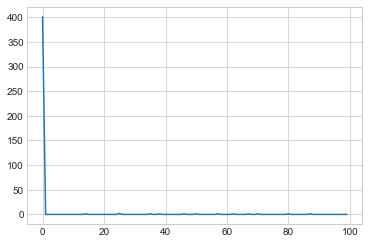

In [10]:
# And now a hacky way to measure the new infections per iteration
# This will be integrated soon in the measurements module.

# Let's reset the model
sir = rec.SIRModel(item_representation=item_representation,
                  user_representation=user_representation,
                  infection_state=infection_state)

# We define a class that does measurements specifically for the SIR model
from rec import Measurements
class SIRMeasurements(Measurements):
    def __init__(self, default_increment = 20, verbose=False):
        self.new_cases = np.zeros(default_increment)
        self._infection_state_old = None
        super().__init__(default_increment=default_increment, verbose=verbose)

    def measure(self, infection_state, num_users, num_items):
        self._measure_new_cases(infection_state, num_users, num_items)
        self._index += 1

    def _measure_new_cases(self, infection_state, num_users, num_items):
        if self.new_cases is None or self._index >= self.new_cases.size:
            self.new_cases = self._expand_array(self.new_cases)
        if self._infection_state_old is None:
            self._infection_state_old = np.zeros((num_users, num_items))
        # num. new infections:
        difference = (np.where(infection_state == 1)[0].shape[0] - 
                      np.where(self._infection_state_old == 1)[0].shape[0])
        self.new_cases[self._index] = difference
        self._infection_state_old = np.copy(infection_state)

sir_measurements = SIRMeasurements()
for step in range(timesteps):
    sir.run(timesteps=1)
    sir_measurements.measure(sir.infection_state, sir.num_users,
                            sir.num_items)

plt.plot(np.arange(timesteps), sir_measurements.new_cases[:sir_measurements._index])
plt.show()